# Model Training

This notebook orchestrates the training process for our Convolutional Neural Network (CNN). We will load the augmented dataset, configure the model and training parameters, execute the training loop with early stopping, and finally, save the best-performing model for later evaluation.

## 1. Setup and Imports

First, we import all necessary libraries and set up the environment, including defining the computation device (GPU or CPU) and setting random seeds for reproducibility.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

# Import custom modules for model architecture and training utilities
from scripts.model_architectures import SimpleCNN
from scripts.train_utils import (
    train_epoch,
    validate_epoch,
    save_checkpoint,
    load_checkpoint,
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up the computation device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


## 2. Data Preparation

In this step, we define the data transformations, load the augmented dataset, split it into training and validation sets, and create data loaders to efficiently feed the data to the model. Corresponding function in train_utils.py: `load_data`

In [5]:
# Define data transformations: resize, convert to tensor, and normalize
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full dataset from the augmented data directory
train_data_dir = "data/augmented/train"
full_dataset = datasets.ImageFolder(root=train_data_dir, transform=data_transforms)

# Split the dataset into training and validation sets (80/20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Create data loaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print dataset summary
print(f"Dataset loaded from: {train_data_dir}")
print(f"Total images: {len(full_dataset)}")
print(f"Number of classes: {len(full_dataset.classes)}")
print(f"Class names: {full_dataset.classes}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")


Dataset loaded from: data/augmented/train
Total images: 200000
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training set size: 160000
Validation set size: 40000


## 3. Model Configuration

Here, we initialize our `SimpleCNN` model and move it to the selected device. We also define the loss function, the optimizer, and a learning rate scheduler to adjust the learning rate based on validation performance.

In [6]:
# Initialize the model and move it to the device
model = SimpleCNN(num_classes=10).to(device)

# Define the loss function (Criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Define a learning rate scheduler to reduce LR on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3
)


## 4. Training Configuration

We set the hyperparameters for the training loop, such as the number of epochs and the patience for early stopping. We also initialize variables to track the best model and lists to store the training history.

In [9]:
# Training hyperparameters
num_epochs = 1
early_stopping_patience = 5

# Initialize tracking variables
best_val_loss = float("inf")
patience_counter = 0

# Lists to store training history for later plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Create directories for saving models and results if they don't exist
os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)

print(f"Training configured for {num_epochs} epochs with early stopping patience of {early_stopping_patience}.")


Training configured for 1 epochs with early stopping patience of 5.


## 5. Model Training

This is the main training loop. For each epoch, we train the model on the training set and then evaluate its performance on the validation set. We save the model checkpoint whenever the validation loss improves and stop training early if there is no improvement for a set number of epochs.

In [10]:
print("Starting training...")
for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # Validate the model
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Check for improvement and save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        save_checkpoint(
            {
                "epoch": epoch + 1,
                "state_dict": model.state_dict(),
                "best_val_loss": best_val_loss,
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            },
            "models/best_model.pth",
        )
        print("  ↳ Validation loss improved. Saving best model!")
    else:
        patience_counter += 1
        print(
            f"  ↳ No improvement. Early stopping counter: {patience_counter}/{early_stopping_patience}"
        )

    # Check for early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs!")
        break

print("\nTraining completed!")


Starting training...


Epoch 1/1:
  Train Loss: 0.3744, Train Acc: 86.69%
  Val Loss: 0.7583, Val Acc: 77.50%
  ↳ Validation loss improved. Saving best model!

Training completed!


## 6. Analyze Training Results

After training, we save the collected metrics (loss and accuracy) and visualize them to understand the model's learning progress and identify potential issues like overfitting.

In [11]:
# Save the training history to numpy arrays
np.save("results/train_losses.npy", np.array(train_losses))
np.save("results/val_losses.npy", np.array(val_losses))
np.save("results/train_accuracies.npy", np.array(train_accuracies))
np.save("results/val_accuracies.npy", np.array(val_accuracies))

print("Training history saved to 'results/' directory.")


Training history saved to 'results/' directory.


Training history plot saved as 'results/training_history.png'.


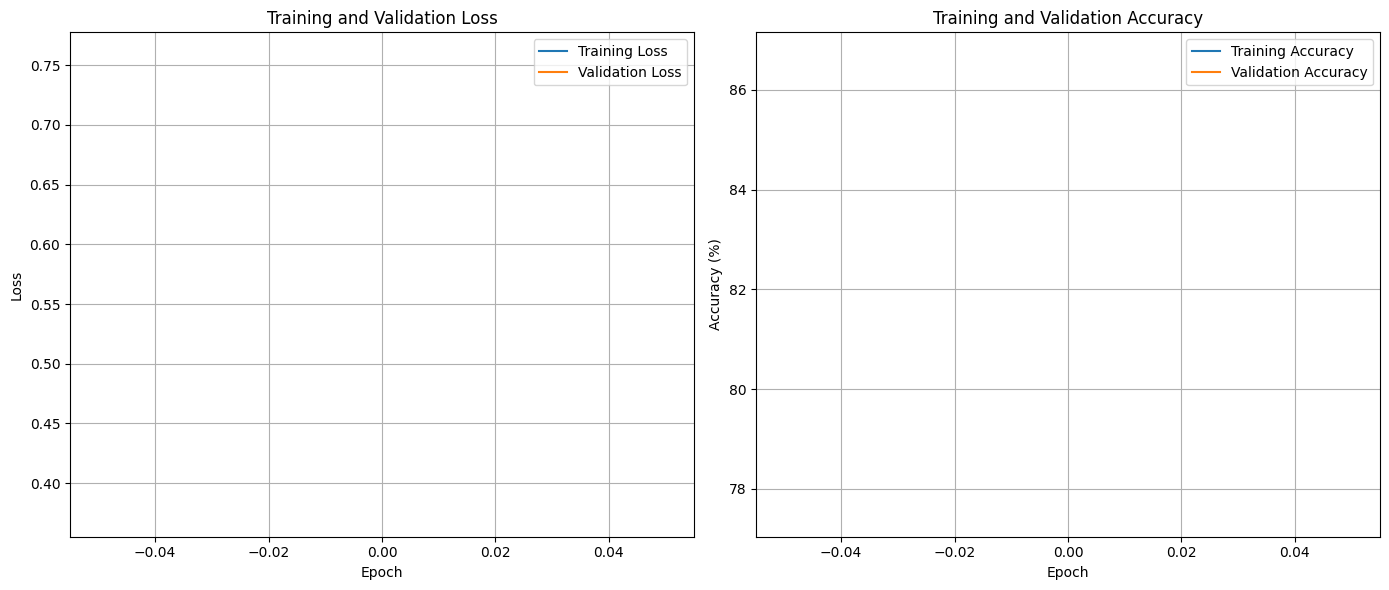

In [12]:
# Plot the training and validation history
plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("results/training_history.png")
print("Training history plot saved as 'results/training_history.png'.")
plt.show()


## 7. Save Final Model

Finally, we load the best-performing checkpoint (based on the lowest validation loss) and save the model's state dictionary. This clean, final model is ready for inference and evaluation in the next notebook.

In [13]:
# Load the best model checkpoint saved during training
checkpoint = torch.load("models/best_model.pth")
model.load_state_dict(checkpoint["state_dict"])

# Retrieve details from the checkpoint
best_epoch = checkpoint["epoch"]
best_val_loss_loaded = checkpoint["best_val_loss"]

print(f"Loaded best model from epoch {best_epoch} with validation loss {best_val_loss_loaded:.4f}")

# Save the final model's state_dict for easy use in evaluation/inference
torch.save(model.state_dict(), "models/final_model.pth")
print("Final model state_dict saved to 'models/final_model.pth'.")

print("\nModel training complete! Proceed to the next notebook for model evaluation.")


Loaded best model from epoch 1 with validation loss 0.7583
Final model state_dict saved to 'models/final_model.pth'.

Model training complete! Proceed to the next notebook for model evaluation.
